In [ ]:
# load packages
from skimage import io, exposure, img_as_ubyte, filters, morphology, measure, color
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [ ]:
# helper functions
def reset_nfig() -> None:
    global nfig
    nfig = 0


def imshow(images, titles, hist=False, cbar=True, *args, **kwargs):
    global nfig

    if not isinstance(images, list):
        images = [images]
        titles = [titles]

    n_images = len(images)

    # Determine the grid size
    ncols = min(n_images, 4)
    nrows = (n_images + 3) // 4  # Ensure there's enough rows

    # If there's only one image, don't create a grid
    if n_images == 1:
        nfig += 1
        if hist:
            # Create a grid with 1 row and 2 columns
            # First column for the histogram, second for the image
            fig = plt.figure(figsize=(6, 4))
            gs = GridSpec(1, 2, width_ratios=[1, 5], wspace=0.1)

            # Histogram on the first column
            ax_hist = fig.add_subplot(gs[0])
            image_data = images[0].flatten()
            ax_hist.hist(
                images[0].ravel(), log=True, bins=256, orientation='horizontal',
                color='black', histtype='step'
            )
            ax_hist.invert_xaxis()  # Invert x-axis to have the histogram on the left
            ax_hist.set_xlabel('Frequency')
            ax_hist.set_ylabel('Intensity')

            # Image on the second column
            ax_image = fig.add_subplot(gs[1])
        else:
            # Just create a figure for the image
            fig, ax_image = plt.subplots(figsize=(6, 6))

        cmap = 'gray' if images[0].ndim == 2 or (images[0].ndim == 3 and images[0].shape[2] == 1) else None
        im = ax_image.imshow(images[0], *args, cmap=cmap, **kwargs)
        if cmap and cbar:  fig.colorbar(im, ax=ax_image)
        ax_image.set_title(f"Figure {nfig}: {titles[0]}")
        ax_image.axis('off')  # Hide axes
        plt.show()
    else:
        # For multiple images, setup is similar without histogram
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))
        axes = axes.flatten()

        for idx, (image, title) in enumerate(zip(images, titles)):
            nfig += 1
            cmap = 'gray' if image.ndim == 2 or (image.ndim == 3 and image.shape[2] == 1) else None
            im = axes[idx].imshow(image, cmap=cmap)
            if cmap and cbar:  fig.colorbar(im, *args, ax=axes[idx], **kwargs)
            axes[idx].set_title(f"Figure {nfig}: {title}")
            axes[idx].axis('off')  # Hide axes

        # Turn off any remaining subplots
        for ax in axes[n_images:]:
            ax.axis('off')

        plt.show()


def watershed_segment(bimg):
    """Apply watershed algorithm"""

    # create distance image
    dist = ndi.distance_transform_edt(bimg)

    # find local maxima
    fp = np.ones((3,) * bimg.ndim)
    coords = peak_local_max(dist, footprint=fp, labels=bimg)

    # create labelled mask
    mask = np.zeros(dist.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)

    # apply watershed algorithm
    labels = watershed(-dist, markers, mask=bimg)

    return labels

> ### Question 1
>
> Load the image "LSM-composite", which is an example taken from your lab samples. The contrast is not very well balanced, and two of the three color channels have additional deficiencies. Process the images to improve the overall color appearance and cleaniness, decribe what you did and show the improved color image [20 pts].

- first, lets look at the original image and each of the channels

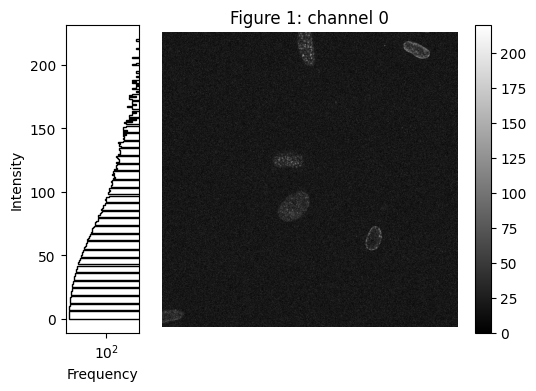

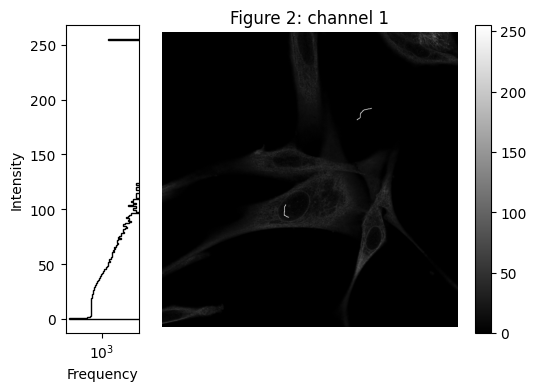

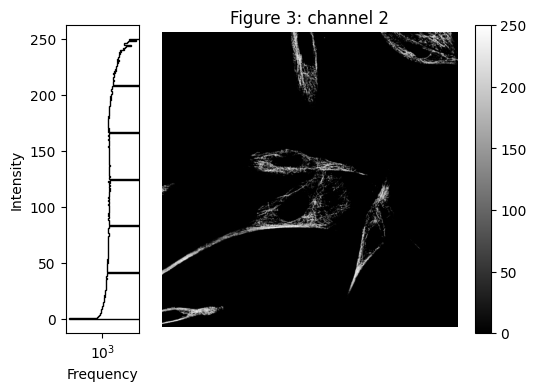

In [ ]:
reset_nfig()

# load original image
img = io.imread("./LSM-Composite.tif")

# make sure image is uint8
if img.dtype != np.uint8:
    img = img_as_ubyte(img)

# visualize color channels separately
R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]

imshow(R, 'channel 0', hist=True)
imshow(G, 'channel 1', hist=True)
imshow(B, 'channel 2', hist=True)

- We see that channel 0 includes a lot of background noise. To deal with this, I:
    - applied a gaussian filter
    - create a mask for intensities > 30
    - apply mask to channel

- In channel 1, we see some artifacts with much higer intensities than the rest of the image. To deal with this, I:
     - filtered out intensities = 255
     - applied contrast stretching to rescale the intensities

- In channel 2, the lower intensities are over represented in the historgam. I dealt with this by applying the CLAHE algorithm to equalize the histogram.

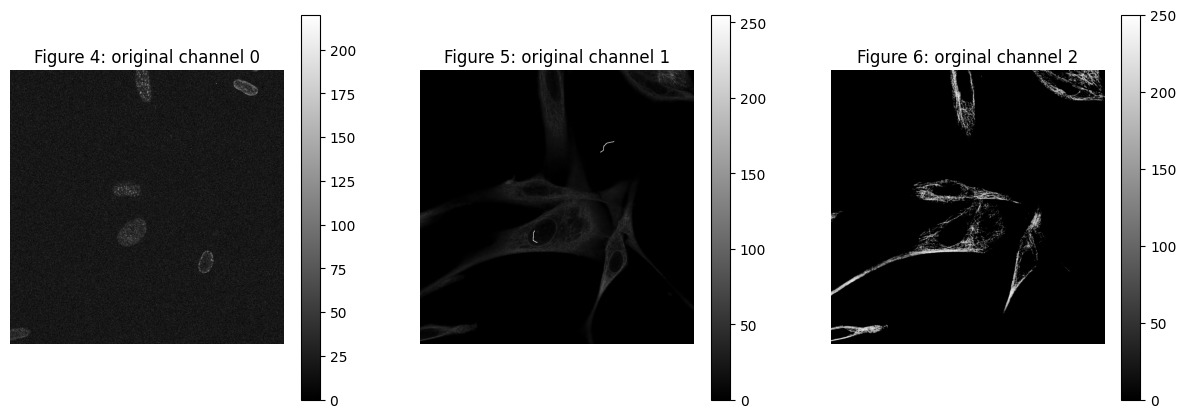

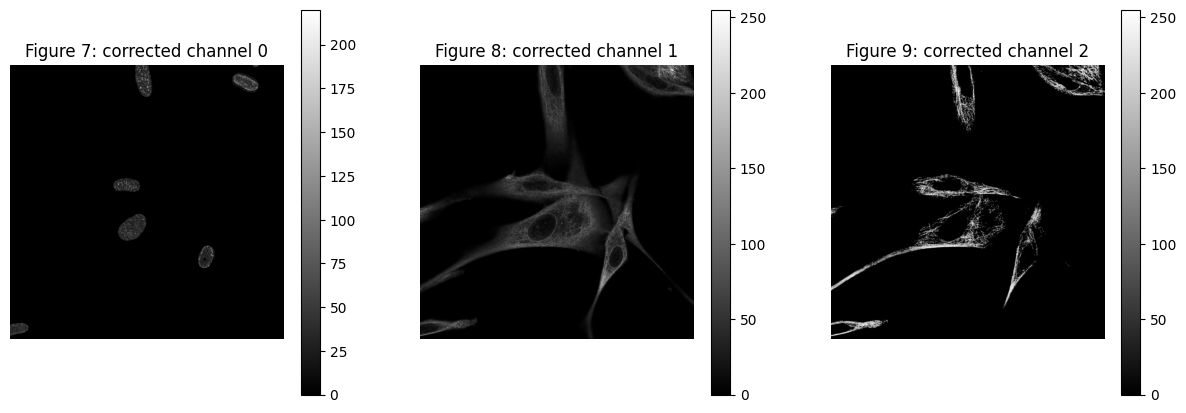

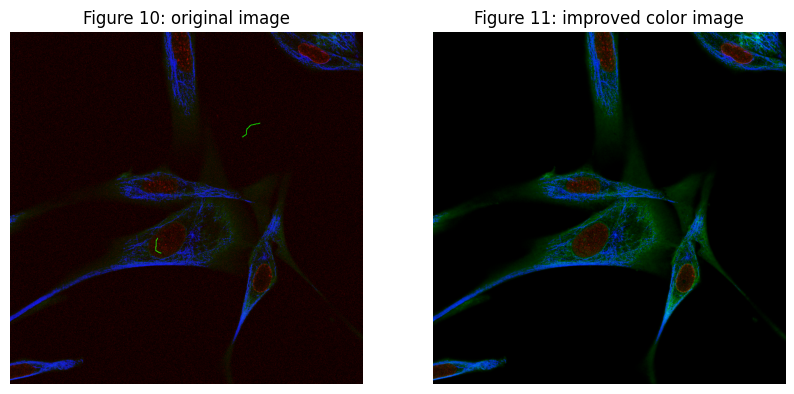

In [ ]:
# channel 0:  gaussian blur -> mask
smoothed = filters.gaussian(R, sigma=10)
smoothed = img_as_ubyte(smoothed)
R_ = np.where(smoothed > 30, R, 0)

# channel 1:  threshold -> contrast stretching
G_ = np.where(G == 255, 0, G)
G_ = exposure.rescale_intensity(G_, in_range=(0, 120))
G_ = img_as_ubyte(G_)

# channel 2: histogram equalization
B_ = exposure.equalize_adapthist(B)
B_ = img_as_ubyte(B_)

# visualize changes
imshow([R, G, B], ["original channel 0", "original channel 1", "orginal channel 2"])
imshow([R_, G_, B_], ["corrected channel 0", "corrected channel 1", "corrected channel 2"])

# combine images
img_ = np.stack([R_, G_, B_], axis=-1)
imshow([img, img_], ["original image", "improved color image"])

> ### Question 2
> Download the image "Beans" posted under the /images folder in BBLearn and select/perform the following image processing steps:
>
> a. Pre-process image for contrast and noise, show the improvement (use a histogram).

In [ ]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.morphology import disk

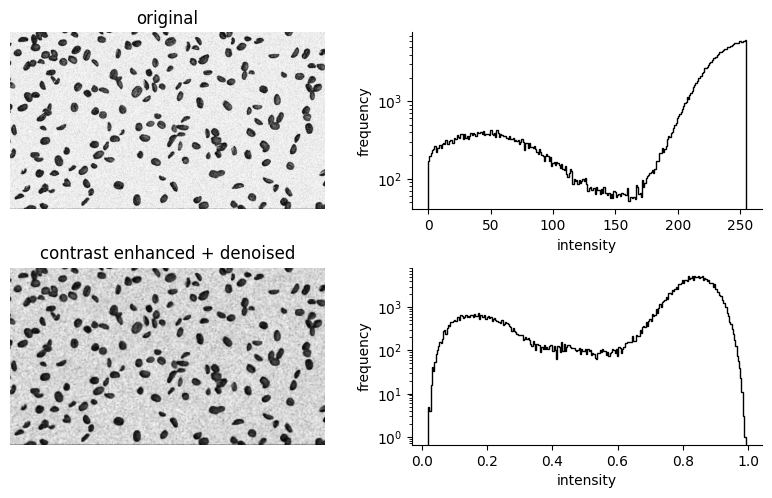

In [ ]:
reset_nfig()

# load original image
img = io.imread("./Beansbw.tif")

# equalize histogram
img_ = exposure.equalize_adapthist(img)

# denoise image
img_ = filters.median(img_, disk(2))

# compare
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

for _I, _ax, _title in zip([img, img_], axes, ['original', 'contrast enhanced + denoised']):
    _ax[0].imshow(_I, cmap='gray', aspect='equal')
    _ax[0].axis('off')
    _ax[0].set_title(_title)

    _ax[1].hist(_I.ravel(), bins=256, log=True, histtype='step', color='black')
    _ax[1].spines[['top', 'right']].set_visible(False)
    _ax[1].set_xlabel('intensity')
    _ax[1].set_ylabel('frequency')

plt.tight_layout()

> b. Threshold the image and provide the threshold value. Document the binary image.



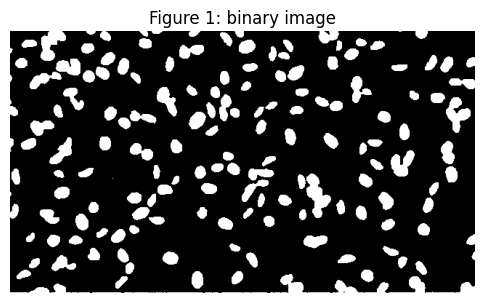

Threshold: 0.5205


In [ ]:
# Otsu's threshold
thresh = filters.threshold_otsu(img_)
bimg = img_ < thresh

imshow(bimg, 'binary image', cbar=False, hist=False)
print(f"Threshold: {thresh:.4f}")

> c. Apply morphological operation(s) to improve the segmentation, include the resulting image and a short description of what you did in your report. Make sure you separate all objects.

To achieve this, i implemented the following:
- apply erosion and dilation to remove small objects / specs in the image
- use the watershed algorithm to perform segmentation; this involved:
  - computing a distance map for the objects in the binary image
  - finding the local maxima of the distance map
  - creating a labelled mask
  - using the watershel algorithm to create the labeled image

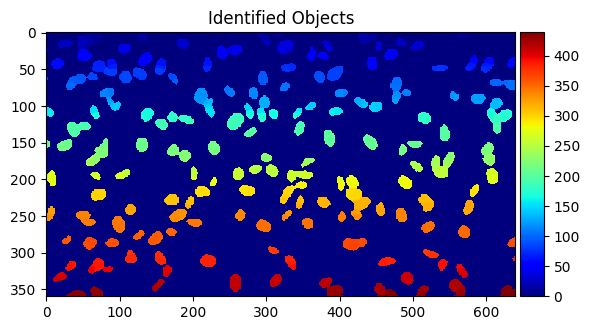

In [ ]:
# Erode and dilate
_img = morphology.binary_erosion(bimg, disk(2))
_img = morphology.binary_dilation(_img, disk(2))

# Segmentation (watershed)
labels = watershed_segment(_img)
fig, ax = plt.subplots(figsize=(6,4))
io.imshow(labels, cmap='jet', ax=ax)
ax.set_title('Identified Objects');

> d. Measure number of objects, mean areas and standard deviation in the binary image, report those numbers in your document. Use "Analyze Particles" under the Analyze tab to perform this task. [50 pts]

In [ ]:
# measure region properties
props = measure.regionprops(labels)

# extract metrics
N = len(props)
areas = [p.area for p in props]
mean = np.mean(areas)
std = np.std(areas)

print(f"""\
  Mean Cell Area:  {mean:.2f} sq px
Std of Cell Area:  {std:.2f} sq px
""")

  Mean Cell Area:  85.92 sq px
Std of Cell Area:  67.90 sq px



> ### Question 3
>
> a. [only BMES 421] Load the image “KAXON”. What is the mean area of the myelin fibers (looking like dark donats)? You may use some of the steps outlined under 2). Document the segmented image. (30 pts)
>
>  b. [only BMES 621] Load the image "Bone".  Perform the necessary steps to measure the size (area) of the dark spine bone in this cross section without the bright center (nerve canal). Next determine the area of the bright canal in the center separatly. Make sure you remove any dirt particles that may arise in the segmentation. Show the segmented images you used for your measurement (hint: consider functions under process/math). [30 pts]


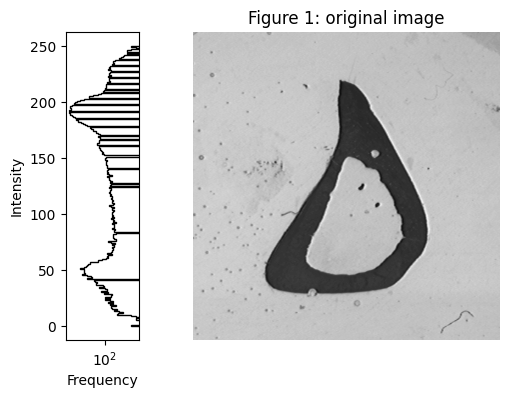

In [ ]:
reset_nfig()

# load original image
img = io.imread("./Bonebw.tiff")

# visualize
imshow(img, 'original image', cbar=False, hist=True)

Areas:
    Spine Bone (dark) = 32365 sq px
        Canal (light) = 19943 sq px



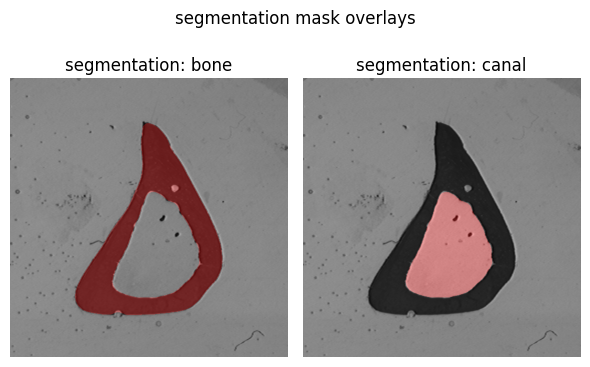

In [ ]:
# threshold image
img_ = img < 120

# erode & dilate
img_ = morphology.binary_erosion(img_, disk(3))
img_ = morphology.binary_dilation(img_, disk(3))

# blur to remove holes
img_ = filters.median(img_, disk(10))

# identify and measure bone
bone_labels = measure.label(img_)
bone_area = measure.regionprops(bone_labels)[0].area

# identify and measure canal
inv = np.invert(img_)
holes, features = ndi.label(inv)
canal_labels = measure.label(holes == 2)
canal_area = measure.regionprops(canal_labels)[0].area

# show segmentation results
fig, axes = plt.subplots(1, 2,  figsize=(6, 4), sharex=True, sharey=True)
for ax, labels, title in zip(axes, [bone_labels, canal_labels], ['bone', 'canal']):
    ax.imshow(
        color.label2rgb(labels, image=img, bg_label=0, colors=['red'])
    )
    ax.set_title(f"segmentation: {title}")
    ax.axis('off')

plt.suptitle("segmentation mask overlays")
plt.tight_layout()

# print results
print(f"""\
Areas:
    Spine Bone (dark) = {bone_area} sq px
        Canal (light) = {canal_area} sq px
""")

**When you compile your homework include all essential images and descriptions of what
you did in your word document/pdf before you submit. Note: There are multiple possible
routes and settings to solve the problems, differences in your submitted solutions are
expected.**